# Modelo de análisis de CVs
El presente archivo presentará la posibilidad de generar con base en 300 HVs tanto rechazadas como avanzadas, un modelo que nos permita identificar las carácterísticas predominantes de una HV que hace que avance o no durante el proceso.


### Importar librerías necesarias

In [44]:
from IPython.display import Image, display
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

### Cargar datos

In [ ]:
data = pd.read_csv('../Bases/base_cvs/baseCVsNUEVO.csv')

### Descriptivo de la base

In [59]:
def describir_base_datos(data):

    print("Información general de la base de datos:\n")
    print(data.info())

    print("\nEstadísticas descriptivas de las variables numéricas:\n")
    print(data.describe())

    print("\nValores únicos de las variables categóricas:\n")
    for columna in data.select_dtypes(include=['object', 'category']).columns:
        print(f"\nColumna: {columna}")
        print(data[columna].unique())

    print("\nFrecuencia de la variable 'Passed':\n")
    print(data['Passed'].value_counts()) # Calcula y muestra las frecuencias de 'target'

    print("\nValores faltantes por columna:\n")
    print(data.isnull().sum())

describir_base_datos(data)

Información general de la base de datos:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 627 entries, 0 to 626
Data columns (total 39 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   Orden Cronológico_No se detectaron suficientes fechas  627 non-null    float64
 1   Orden Cronológico_Orden Cronológico                    627 non-null    float64
 2   Formato de Texto_Mixto                                 627 non-null    float64
 3   Formato de Texto_Párrafos                              627 non-null    float64
 4   Formato de Texto_Viñetas                               627 non-null    float64
 5   Legibilidad_Buena                                      627 non-null    float64
 6   Legibilidad_Deficiente                                 627 non-null    float64
 7   Uso de colores (excluyendo fondo blanco y links)_No    627 non-null    float64
 8   Uso de c

### División de la base en Train y Test

In [60]:
x_train, x_test, y_train, y = train_test_split(data, data['Passed'], test_size=0.3, random_state=69)

print("Forma de x_train:", x_train.shape)
print("Forma de x_test:", x_test.shape)
print("Forma de y_train:", y_train.shape)
print("Forma de y:", y.shape)

Forma de x_train: (438, 39)
Forma de x_test: (189, 39)
Forma de y_train: (438,)
Forma de y: (189,)


# Validamos si necesitamos escalado
Inicialmente al usar un modelo basado en árboles no necesitamos escalado.



# Análisis con Random Forest para conseguir prestaciones top baseline

Vamos a realizar una estimación de las prestaciones más precisas que podríamos alcanzar al modelar esta base de datos con aprendizaje automático.

Para ello emplearemos *Random Forest* buscando valores para el número de hojas y el tamaño del bosque.

In [61]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, roc_auc_score

def analizar_random_forest_optimo(data, target_col='Passed', test_size=0.3, random_state=42, cv_splits=3):

    x = data.drop(columns=[target_col])
    y = data[target_col]

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=random_state, stratify=y)

    rf = RandomForestClassifier(random_state=random_state)

    param_grid = {
        'n_estimators': [100, 300, 500, 700, 900],
        'max_depth': [5, 10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=random_state)
    grid_search = GridSearchCV(rf, param_grid, cv=cv, scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'], refit='accuracy', n_jobs=-1, verbose=0)
    grid_search.fit(x_train, y_train)

    best_rf = grid_search.best_estimator_

    y_pred = best_rf.predict(x_test)
    y_pred_proba = best_rf.predict_proba(x_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    print("Mejores hiperparámetros:", grid_search.best_params_)
    print("Precisión:", accuracy)
    print("Precisión:", precision)
    print("Recuperación:", recall)
    print("Puntuación F1:", f1)
    print("AUC ROC:", roc_auc)
    print("Reporte de clasificación:\n", classification_report(y_test, y_pred))

    #Extra#
    feature_importances = pd.Series(best_rf.feature_importances_, index=x_train.columns).sort_values(ascending=False)
    print("\nRanking de variables por importancia de Random Forest:")
    print(feature_importances)

    return grid_search.best_params_, (accuracy, precision, recall, f1, roc_auc), feature_importances


In [62]:
mejores_params, metrics, ranking_variables = analizar_random_forest_optimo(data)

Mejores hiperparámetros: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Precisión: 0.544973544973545
Precisión: 0.36363636363636365
Recuperación: 0.1
Puntuación F1: 0.1568627450980392
AUC ROC: 0.4723050458715597
Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.57      0.87      0.69       109
           1       0.36      0.10      0.16        80

    accuracy                           0.54       189
   macro avg       0.47      0.49      0.42       189
weighted avg       0.48      0.54      0.46       189


Ranking de variables por importancia de Random Forest:
Cantidad de Palabras                                     0.104071
Porcentaje de color real en la CV                        0.099056
Uso de negritas                                          0.097080
Densidad de Información                                  0.095481
 % Lenguaje de Técnico                                   0.086047
Uso de cu

In [63]:
from sklearn.feature_selection import mutual_info_classif

def analizar_relevancia_informacion_mutua(dta_ohe, target_col='Passed', test_size=0.3, random_state=42):

    X = dta_ohe.drop(columns=[target_col])
    y = dta_ohe[target_col]

    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    f_test = mutual_info_classif(x_train, y_train, random_state=random_state)
    feature_scores = pd.Series(f_test, index=x_train.columns).sort_values(ascending=False)

    print("Ranking de variables por información mutua:")
    print(feature_scores)

    plt.figure(figsize=(10, len(feature_scores) * 0.3))
    sns.barplot(x=feature_scores, y=feature_scores.index)
    plt.title("Información mutua por variable")
    plt.xlabel("Puntuación de información mutua")
    plt.ylabel("Variable")
    plt.show()

    return feature_scores

Ranking de variables por información mutua:
skills                                                   0.033315
Uso de negritas                                          0.031788
training_courses                                         0.025668
LinkedIn                                                 0.024372
GitHub                                                   0.022868
Porcentaje de color real en la CV                        0.017699
achievements                                             0.017399
Uso de colores (excluyendo fondo blanco y links)_No      0.013178
Páginas                                                  0.013065
Formato de Texto_Párrafos                                0.012992
publications                                             0.012324
Alineación principal_Justificado                         0.011694
Consistencia de márgenes_Inconsistente                   0.011190
Consistencia de márgenes_Consistente                     0.010988
Consistencia de tamaños_Consiste

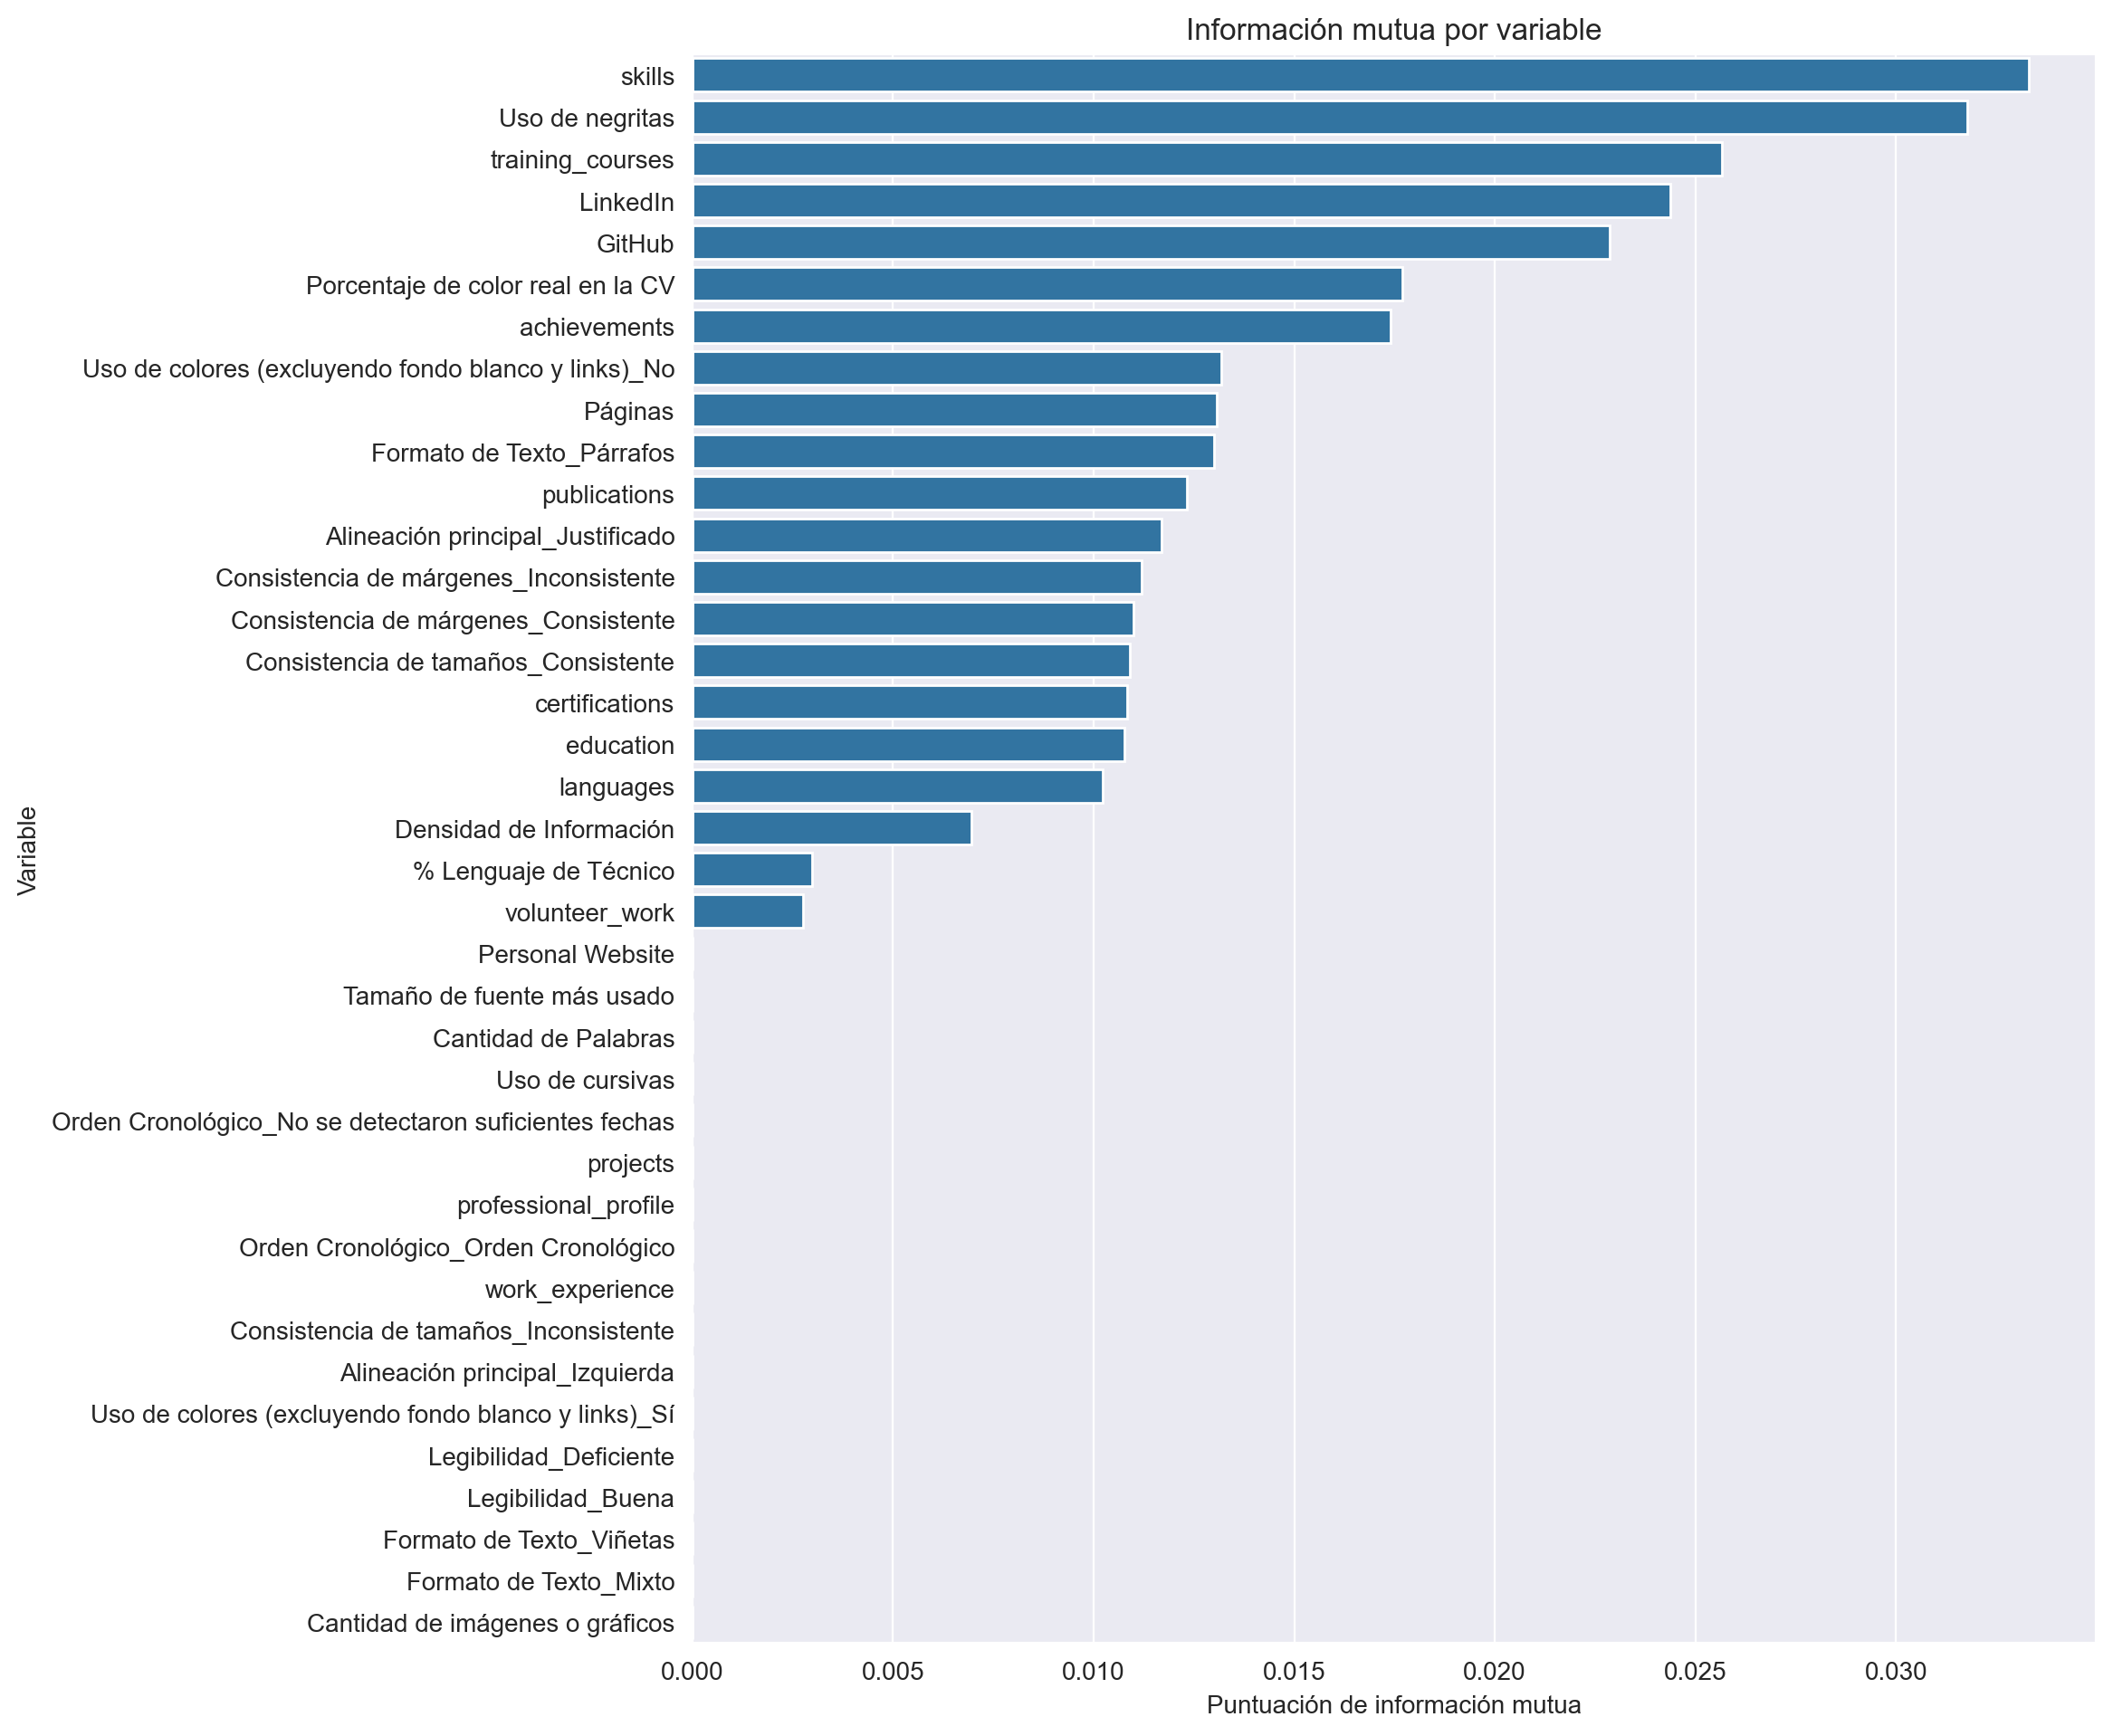

In [64]:
feature_scores = analizar_relevancia_informacion_mutua(data)

## Selección de variables con información mutua y validación cruzada


In [65]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, roc_auc_score

def seleccionar_variables_knn_varias_k(data, target_col='Passed', test_size=0.3, random_state=69, cv_splits=3, k_values=[10, 20, 21]):

    X = data.drop(columns=[target_col])
    y = data[target_col]

    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

    resultados = {}
    for k in k_values:
        pipeline = Pipeline([
            ('select', SelectKBest(score_func=mutual_info_classif, k=k)),
            ('scaler', StandardScaler()),
            ('knn', KNeighborsClassifier())
        ])

        param_grid = {
            'knn__n_neighbors': [3, 5, 7, 10, 15],
            'knn__weights': ['uniform', 'distance']
        }

        cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=random_state)
        grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'], refit='accuracy', n_jobs=-1, verbose=0)
        grid_search.fit(x_train, y_train)

        best_params = grid_search.best_params_
        best_knn = grid_search.best_estimator_

        y_pred = best_knn.predict(x_test)
        y_pred_proba = best_knn.predict_proba(x_test)[:, 1]

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        # Obtener las variables seleccionadas
        selected_features = x_train.columns[grid_search.best_estimator_.named_steps['select'].get_support()]
        riesgo_entrenamiento = grid_search.score(x_train, y_train)
        riesgo_test = grid_search.score(x_test, y_test)

        resultados[k] = {
            'best_params': best_params,
            'metrics': (accuracy, precision, recall, f1, roc_auc),
            'model': best_knn,
            'selected_features': selected_features  # Agregar las variables seleccionadas
        }

        print(f"Resultados para k={k}:")
        print("Mejores hiperparámetros:", best_params)
        print("Precisión:", accuracy)
        print("Precisión:", precision)
        print("Recuperación:", recall)
        print("Puntuación F1:", f1)
        print("AUC ROC:", roc_auc)
        print("Reporte de clasificación:\n", classification_report(y_test, y_pred))
        print("Acierto en el conjunto de entrenamiento: {0:.2f}(%)".format(100.*riesgo_entrenamiento))
        print("Acierto en el conjunto de test: {0:.2f}(%)".format(100.*riesgo_test))
        print("Variables seleccionadas:", selected_features)  # Imprimir las variables seleccionadas

    return resultados

In [66]:
resultados_knn = seleccionar_variables_knn_varias_k(data)

Resultados para k=10:
Mejores hiperparámetros: {'knn__n_neighbors': 10, 'knn__weights': 'distance'}
Precisión: 0.5502645502645502
Precisión: 0.463768115942029
Recuperación: 0.4
Puntuación F1: 0.42953020134228187
AUC ROC: 0.5009174311926605
Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.60      0.66      0.63       109
           1       0.46      0.40      0.43        80

    accuracy                           0.55       189
   macro avg       0.53      0.53      0.53       189
weighted avg       0.54      0.55      0.54       189

Acierto en el conjunto de entrenamiento: 98.17(%)
Acierto en el conjunto de test: 55.03(%)
Variables seleccionadas: Index(['Formato de Texto_Viñetas', 'Consistencia de márgenes_Inconsistente',
       'Páginas', 'certifications', 'achievements', 'professional_profile',
       'volunteer_work', ' % Lenguaje de Técnico',
       'Tamaño de fuente más usado', 'Porcentaje de color real en la CV'],
      dtype

## Agregar variables al modelo


In [67]:
def agregar_variables_recursivamente(data, target_col='Passed', test_size=0.3, random_state=42):
    """
    Agrega variables al modelo recursivamente y grafica la precisión.

    Args:
        dta_ohe (pd.DataFrame): DataFrame con variables codificadas one-hot.
        target_col (str): Nombre de la columna objetivo.
        test_size (float): Tamaño del conjunto de prueba.
        random_state (int): Semilla para reproducibilidad.

    Returns:
        tuple: Orden de variables añadidas y lista de precisiones en prueba.
    """
    X = data.drop(columns=[target_col])
    y = data[target_col]

    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

    orden_variables = []
    precisiones_test = []

    variables_actuales = []
    for _ in range(X.shape[1]):
        mejores_variables = []
        mejor_precision = 0

        variables_restantes = [col for col in X.columns if col not in variables_actuales]
        for variable in variables_restantes:
            variables_prueba = variables_actuales + [variable]
            model = RandomForestClassifier(random_state=random_state)
            model.fit(x_train[variables_prueba], y_train)
            y_pred = model.predict(x_test[variables_prueba])
            precision = accuracy_score(y_test, y_pred)

            if precision > mejor_precision:
                mejor_precision = precision
                mejores_variables = variables_prueba + []

        variables_actuales = mejores_variables
        orden_variables.append(variables_actuales[-1])
        precisiones_test.append(mejor_precision)

    print("Orden de variables añadidas:", orden_variables)

    plt.plot(range(1, len(precisiones_test) + 1), precisiones_test)
    plt.xlabel("Número de variables")
    plt.ylabel("Precisión en prueba")
    plt.title("Precisión vs. Número de variables añadidas")
    plt.show()

    return orden_variables, precisiones_test

Orden de variables añadidas: ['Uso de cursivas', 'volunteer_work', 'LinkedIn', 'Formato de Texto_Mixto', 'Alineación principal_Izquierda', 'Personal Website', 'Alineación principal_Justificado', 'achievements', 'Formato de Texto_Viñetas', 'GitHub', 'Orden Cronológico_No se detectaron suficientes fechas', 'Orden Cronológico_Orden Cronológico', 'education', 'Formato de Texto_Párrafos', 'Consistencia de tamaños_Inconsistente', 'Legibilidad_Buena', 'Consistencia de tamaños_Consistente', 'Legibilidad_Deficiente', 'Uso de colores (excluyendo fondo blanco y links)_Sí', 'Uso de colores (excluyendo fondo blanco y links)_No', 'work_experience', 'publications', ' % Lenguaje de Técnico', 'projects', 'Cantidad de imágenes o gráficos', 'Consistencia de márgenes_Consistente', 'Uso de negritas', 'Cantidad de Palabras', 'Porcentaje de color real en la CV', 'Consistencia de márgenes_Inconsistente', 'training_courses', 'Páginas', 'professional_profile', 'skills', 'Densidad de Información', 'Tamaño de fue

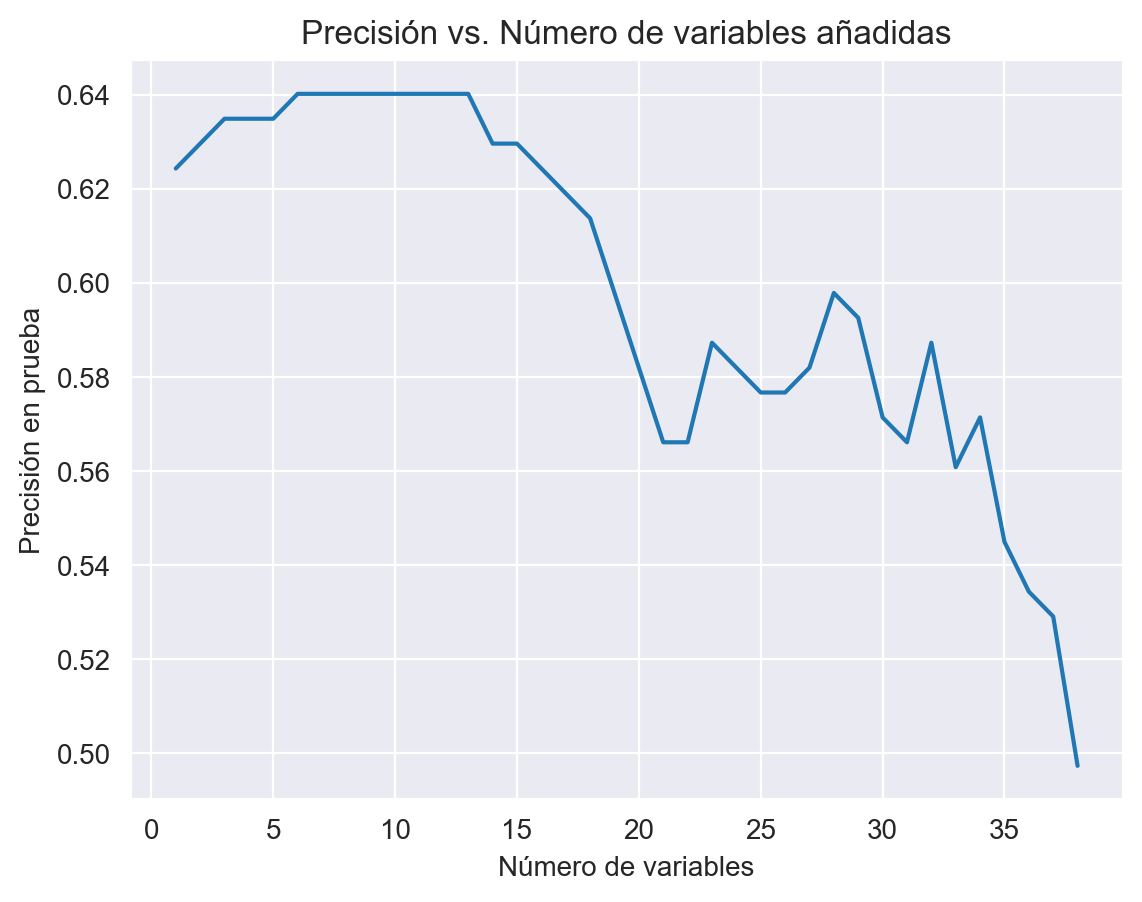

In [68]:
orden_vars_suma, precisiones_suma = agregar_variables_recursivamente(data)


### Eliminar variables de acuerdo a lo que nos mostró este resultado

In [70]:
data_modelo_sumar_variables = data.drop(['Uso de cursivas', 'volunteer_work', 'LinkedIn', 'Formato de Texto_Mixto', 'Alineación principal_Izquierda', 'Personal Website', 'Alineación principal_Justificado', 'achievements', 'Formato de Texto_Viñetas', 'GitHub', 'Orden Cronológico_No se detectaron suficientes fechas', 'Orden Cronológico_Orden Cronológico', 'education'], axis=1)


In [71]:
mejores_params_suma_var, metrics_suma_var, ranking_variables_var = analizar_random_forest_optimo(data_modelo_sumar_variables)

Mejores hiperparámetros: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Precisión: 0.5238095238095238
Precisión: 0.32142857142857145
Recuperación: 0.1125
Puntuación F1: 0.16666666666666666
AUC ROC: 0.46622706422018345
Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.56      0.83      0.67       109
           1       0.32      0.11      0.17        80

    accuracy                           0.52       189
   macro avg       0.44      0.47      0.42       189
weighted avg       0.46      0.52      0.46       189


Ranking de variables por importancia de Random Forest:
Densidad de Información                                0.135186
Cantidad de Palabras                                   0.129978
Uso de negritas                                        0.118162
Porcentaje de color real en la CV                      0.097317
 % Lenguaje de Técnico                                 0.088423
Tamaño de fuen

### Eliminar Variables del modelo

In [72]:
def eliminar_variables_recursivamente(dta_ohe, target_col='Passed', test_size=0.3, random_state=69):

    X = dta_ohe.drop(columns=[target_col])
    y = dta_ohe[target_col]

    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

    orden_variables = []
    precisiones_test = []

    variables_actuales = list(X.columns)
    while len(variables_actuales) > 1:
        peor_variable = None
        mejor_precision = 0

        for variable in variables_actuales:
            variables_prueba = [v for v in variables_actuales if v != variable]
            model = RandomForestClassifier(random_state=random_state)
            model.fit(x_train[variables_prueba], y_train)
            y_pred = model.predict(x_test[variables_prueba])
            precision = accuracy_score(y_test, y_pred)

            if precision > mejor_precision:
                mejor_precision = precision
                peor_variable = variable

        variables_actuales.remove(peor_variable)
        orden_variables.append(peor_variable)
        precisiones_test.append(mejor_precision)

    print("Orden de variables eliminadas:", orden_variables)

    plt.plot(range(len(precisiones_test), 0, -1), precisiones_test)
    plt.xlabel("Número de variables")
    plt.ylabel("Precisión en prueba")
    plt.title("Precisión vs. Número de variables eliminadas")
    plt.show()

    return orden_variables, precisiones_test

Orden de variables eliminadas: ['Consistencia de tamaños_Consistente', 'Formato de Texto_Mixto', 'Cantidad de imágenes o gráficos', 'GitHub', 'Uso de negritas', 'skills', 'Consistencia de márgenes_Inconsistente', 'professional_profile', 'Densidad de Información', 'work_experience', 'Formato de Texto_Viñetas', ' % Lenguaje de Técnico', 'Legibilidad_Deficiente', 'projects', 'Porcentaje de color real en la CV', 'publications', 'Uso de cursivas', 'Alineación principal_Izquierda', 'Uso de colores (excluyendo fondo blanco y links)_Sí', 'Consistencia de tamaños_Inconsistente', 'LinkedIn', 'education', 'volunteer_work', 'Formato de Texto_Párrafos', 'Orden Cronológico_No se detectaron suficientes fechas', 'Alineación principal_Justificado', 'training_courses', 'Páginas', 'certifications', 'Personal Website', 'Orden Cronológico_Orden Cronológico', 'languages', 'Legibilidad_Buena', 'Uso de colores (excluyendo fondo blanco y links)_No', 'Cantidad de Palabras', 'achievements', 'Tamaño de fuente más

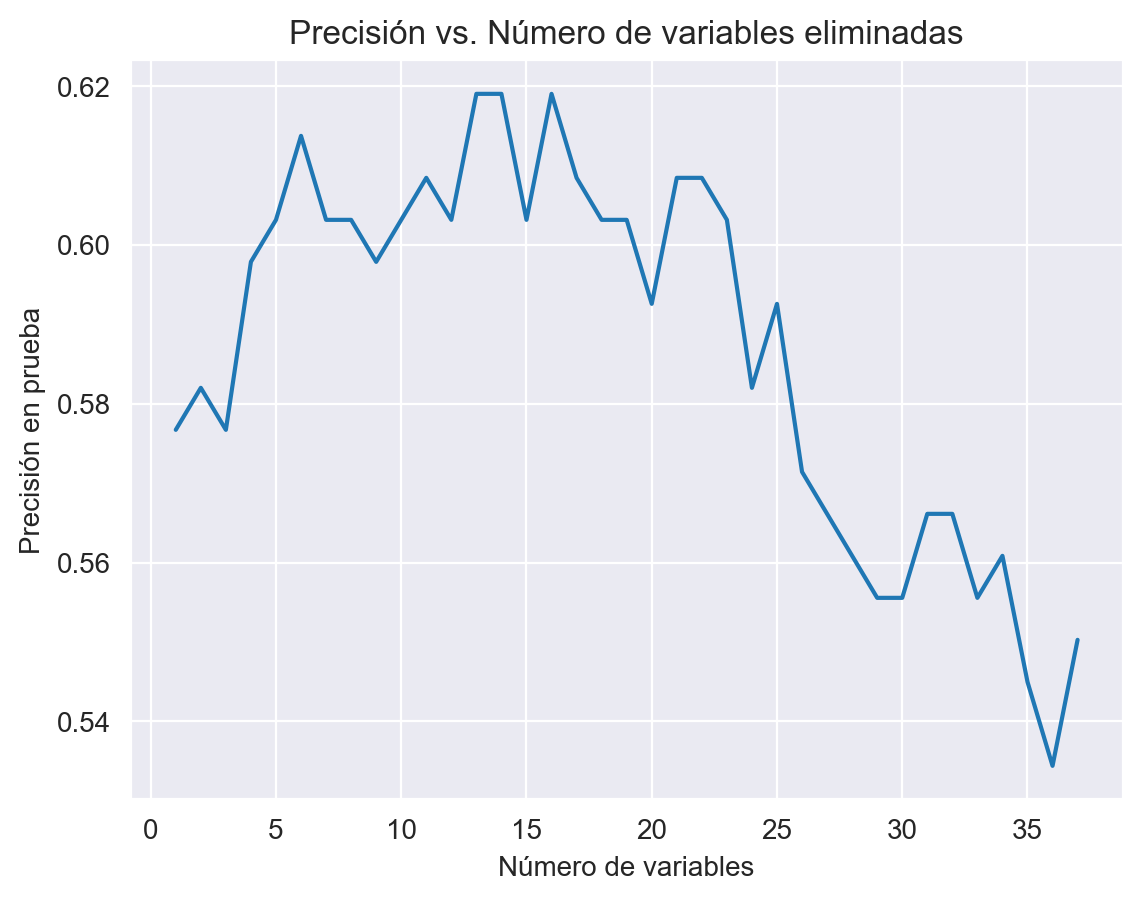

In [73]:
orden_vars_resta, precisiones_resta = eliminar_variables_recursivamente(data)

In [74]:
data_modelo_restar_variables = data.drop(['Consistencia de tamaños_Consistente', 'Formato de Texto_Mixto', 'Cantidad de imágenes o gráficos', 'GitHub', 'Uso de negritas', 'skills', 'Consistencia de márgenes_Inconsistente', 'professional_profile', 'Densidad de Información', 'work_experience', 'Formato de Texto_Viñetas', ' % Lenguaje de Técnico', 'Legibilidad_Deficiente', 'projects'], axis=1)

In [75]:
mejores_params_resta_var, metrics_resta_var, ranking_variables_resta_var = analizar_random_forest_optimo(data_modelo_restar_variables)

Mejores hiperparámetros: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Precisión: 0.5343915343915344
Precisión: 0.36666666666666664
Recuperación: 0.1375
Puntuación F1: 0.2
AUC ROC: 0.48836009174311923
Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.57      0.83      0.67       109
           1       0.37      0.14      0.20        80

    accuracy                           0.53       189
   macro avg       0.47      0.48      0.44       189
weighted avg       0.48      0.53      0.47       189


Ranking de variables por importancia de Random Forest:
Cantidad de Palabras                                     0.156264
Porcentaje de color real en la CV                        0.137642
Tamaño de fuente más usado                               0.107504
Uso de cursivas                                          0.106051
Páginas                                                  0.090028
languages          

## Ranking de variables

In [76]:
def obtener_importancia_rf(dta_ohe, target_col='Passed', test_size=0.3, random_state=69):

    X = data.drop(columns=[target_col])
    y = data[target_col]

    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

    model = RandomForestClassifier(random_state=random_state)
    model.fit(x_train, y_train)

    feature_importances = pd.Series(model.feature_importances_, index=x_train.columns).sort_values(ascending=False)

    print("Ranking de variables por importancia de Random Forest:")
    print(feature_importances)

    plt.figure(figsize=(10, len(feature_importances) * 0.3))
    sns.barplot(x=feature_importances, y=feature_importances.index)
    plt.title("Importancia de variables de Random Forest")
    plt.xlabel("Importancia")
    plt.ylabel("Variable")
    plt.show()

    return feature_importances


Ranking de variables por importancia de Random Forest:
 % Lenguaje de Técnico                                   0.101719
Uso de negritas                                          0.101414
Densidad de Información                                  0.099064
Cantidad de Palabras                                     0.097785
Porcentaje de color real en la CV                        0.085442
Tamaño de fuente más usado                               0.054085
Cantidad de imágenes o gráficos                          0.052396
Uso de cursivas                                          0.049639
Páginas                                                  0.043536
training_courses                                         0.019414
languages                                                0.018958
professional_profile                                     0.018775
certifications                                           0.018292
skills                                                   0.017413
publications         

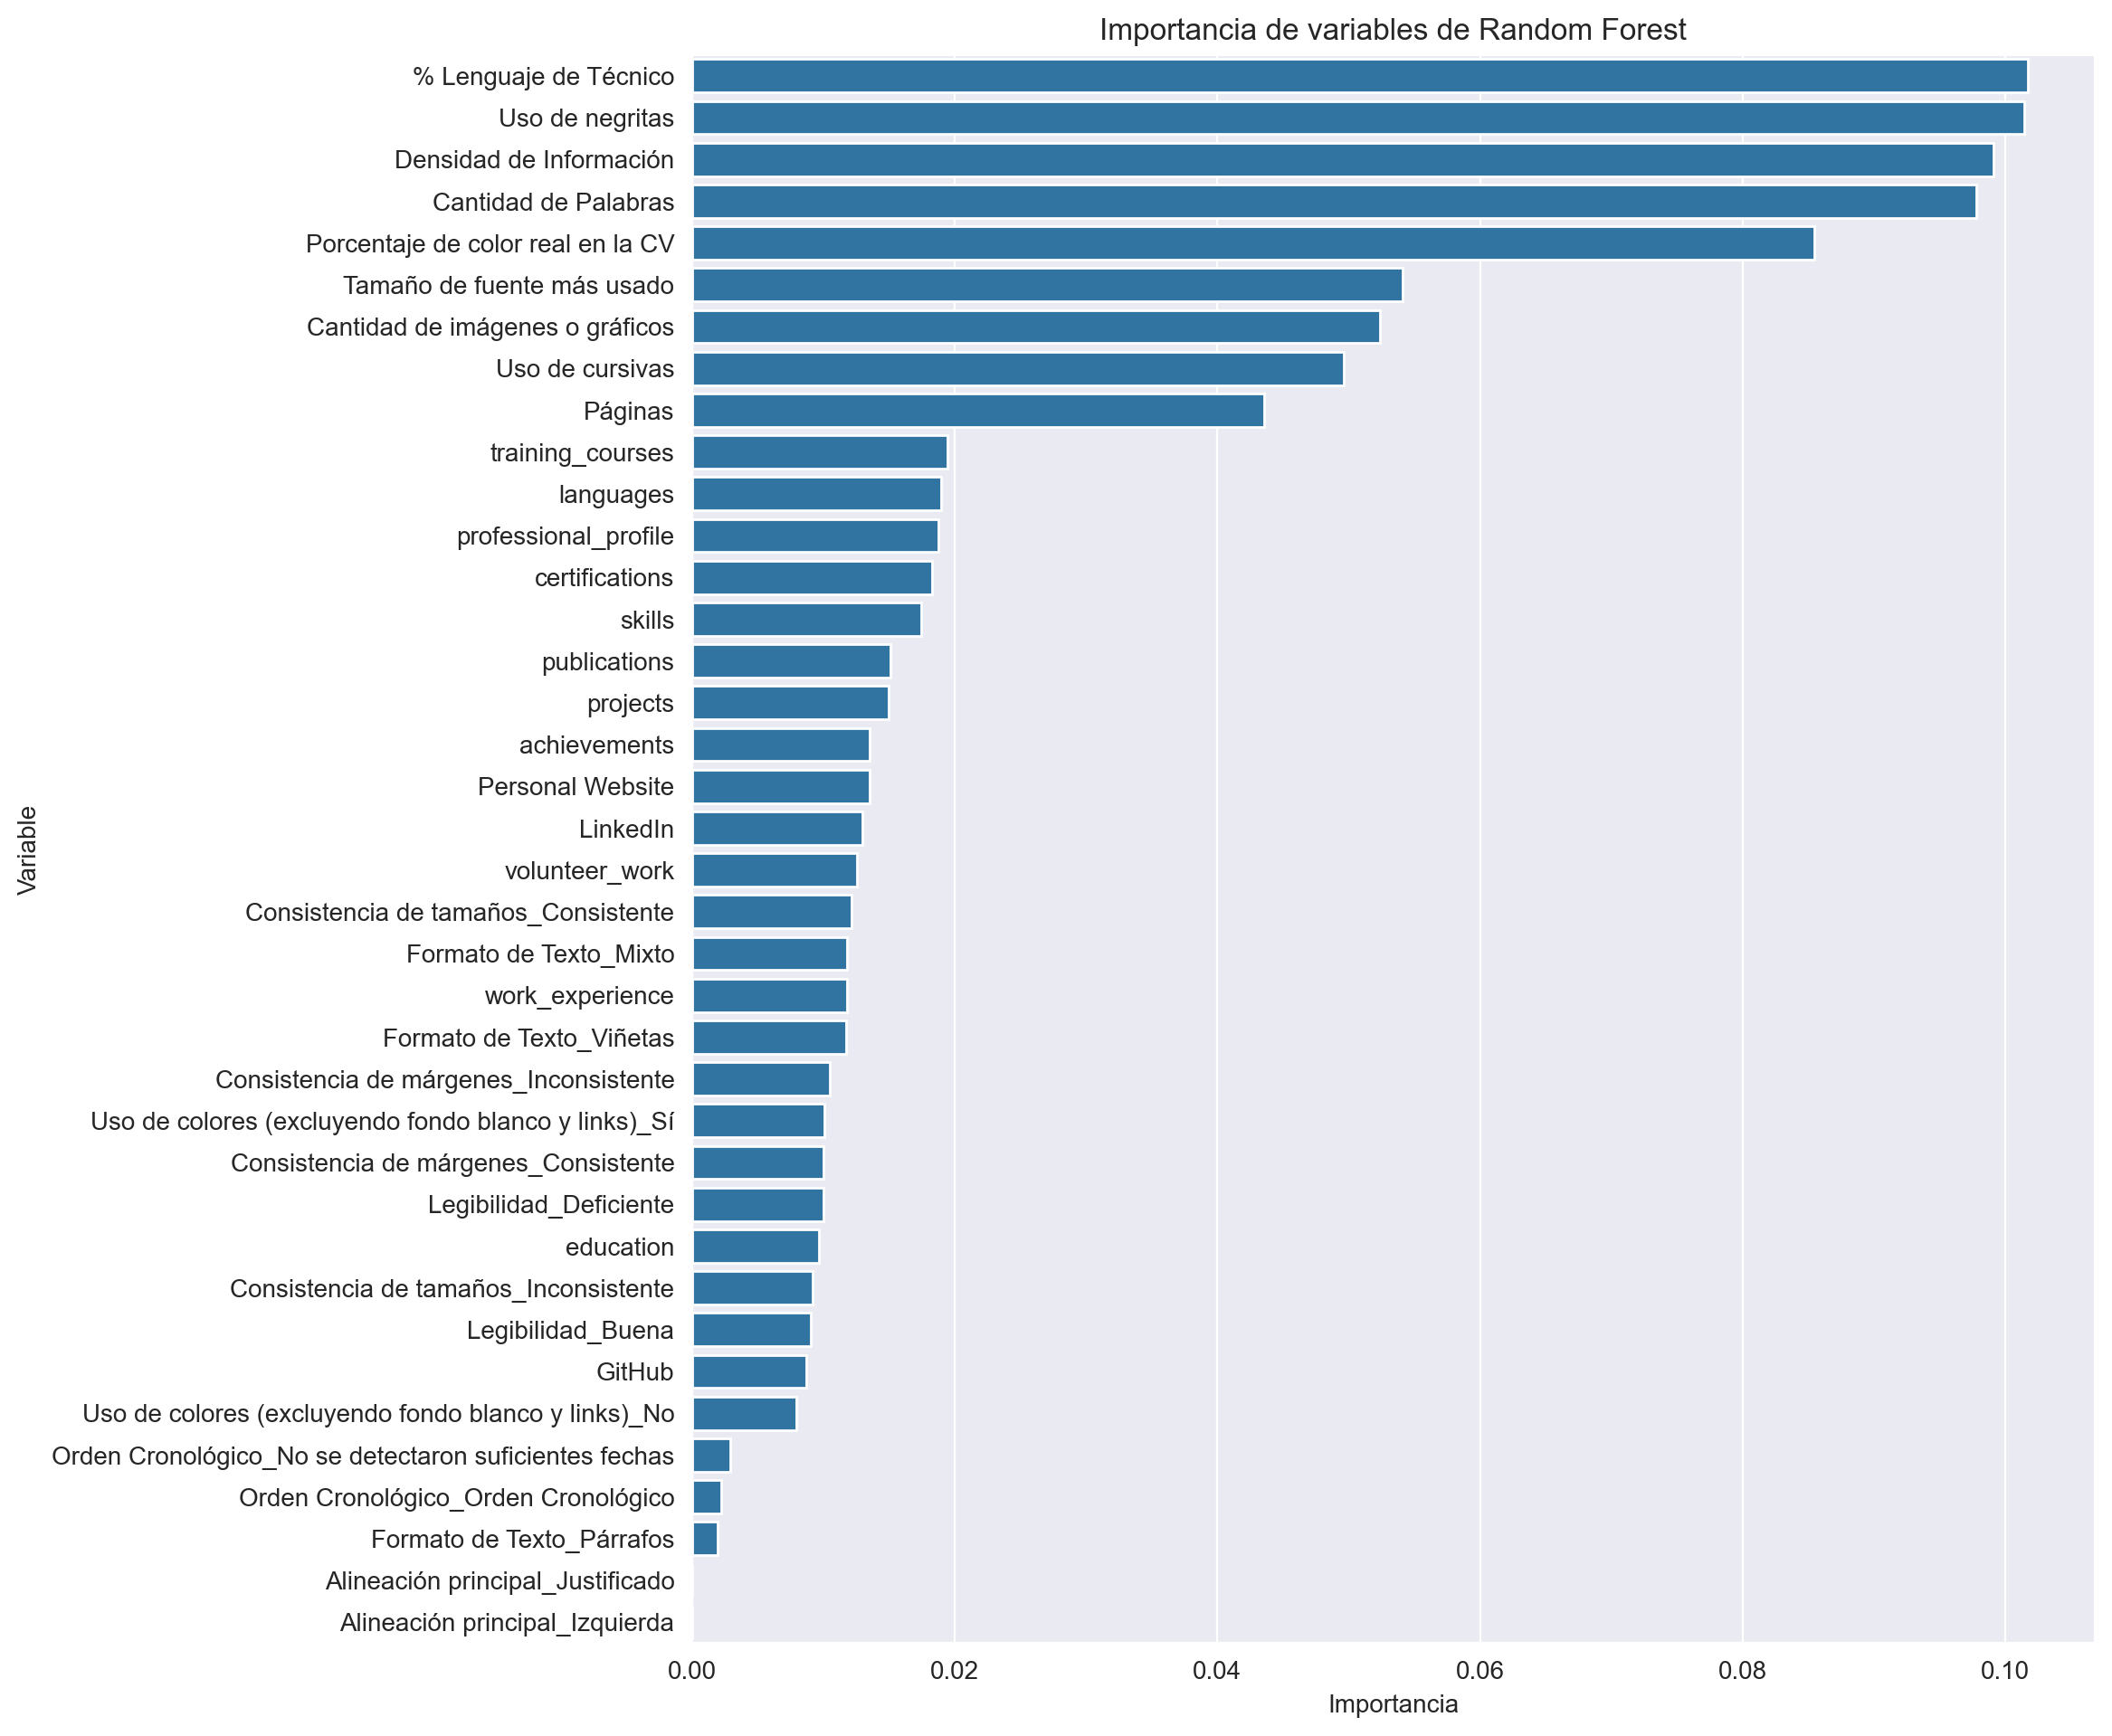

In [77]:
importancia_rf = obtener_importancia_rf(data)

# prueba con nuevo script ajustando muestra


In [72]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# 📌 Step 1: Load the dataset
df = pd.read_csv("../Bases/base_cvs/baseCVs.csv")

# 📌 Step 2: Define features & target variable
X = df.drop(columns=["Passed"])  # Features
y = df["Passed"]  # Target (0 = rejected, 1 = selected)

# 📌 Step 3: Remove low-importance features
low_importance_features = ["Has_Colors", "volunteer_work_Exists", "volunteer_work_Word_Count", "Has_Photo"]
X = X.drop(columns=low_importance_features)

# 📌 Step 4: Split data into train & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 📌 Step 5: Handle Class Imbalance
# Choose between SMOTE (Oversampling) or Undersampling
use_smote = True  # Change to False to use undersampling instead

if use_smote:
    smote = SMOTE(sampling_strategy="auto", random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)
else:
    undersample = RandomUnderSampler(sampling_strategy=0.5, random_state=42)
    X_train, y_train = undersample.fit_resample(X_train, y_train)

# 📌 Step 6: Hyperparameter tuning with GridSearchCV
param_grid = {
    "n_estimators": [500, 700, 1000],  # Number of trees
    "max_depth": [5, 10, 15],  # Depth of trees
    "min_samples_split": [2, 5, 10],  # Min samples to split a node
    "min_samples_leaf": [1, 3, 5],  # Min samples per leaf
}

rf = RandomForestClassifier(random_state=69)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring="f1", n_jobs=-1)
grid_search.fit(X_train, y_train)

# 📌 Step 7: Train the best model
best_rf = grid_search.best_estimator_
best_rf.fit(X_train, y_train)

# 📌 Step 8: Evaluate the model
y_pred = best_rf.predict(X_test)
y_pred_proba = best_rf.predict_proba(X_test)[:, 1]

# 📌 Step 9: Print Metrics
print("🔹 Best Hyperparameters:", grid_search.best_params_)
print("🔹 AUC-ROC Score:", roc_auc_score(y_test, y_pred_proba))
print("\n🔹 Classification Report:\n", classification_report(y_test, y_pred))

# 📌 Step 10: Cross-Validation for Stability
cv_scores = cross_val_score(best_rf, X_train, y_train, cv=5, scoring="f1")
print("\n🔹 Cross-Validation F1 Score:", np.mean(cv_scores))

# 📌 Step 11: Feature Importance Ranking
feature_importances = pd.Series(best_rf.feature_importances_, index=X.columns)
feature_importances = feature_importances.sort_values(ascending=False)
print("\n🔹 Feature Importance:\n", feature_importances)


🔹 Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
🔹 AUC-ROC Score: 0.5160183066361557

🔹 Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.82      0.71        38
           1       0.42      0.22      0.29        23

    accuracy                           0.59        61
   macro avg       0.52      0.52      0.50        61
weighted avg       0.55      0.59      0.55        61


🔹 Cross-Validation F1 Score: 0.6562340000696165

🔹 Feature Importance:
 Keyword_Ratio                      0.089091
Education_Word_Count               0.085909
Total_Word_Count                   0.085517
Professional_Profile_Word_Count    0.084620
Work_Experience_Word_Count         0.083249
Keyword_Count                      0.074890
Skills_Word_Count                  0.069636
Pages                              0.062010
projects_Word_Count                0.051189
Education_Level_unknown        

### El modelo no funcionó bien con random forest, necesita ajuste.

Intentaremos con xGBoost

In [73]:
import xgboost as xgb
from imblearn.combine import SMOTEENN

# Remove non-numeric columns
if "CV_Name" in df.columns:
    df = df.drop(columns=["CV_Name"])

if "CV_Type" in df.columns:
    df = df.drop(columns=["CV_Type"])

# 📌 Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 📌 Apply SMOTEENN to balance classes
smoteenn = SMOTEENN(random_state=42)
X_train_resampled, y_train_resampled = smoteenn.fit_resample(X_train, y_train)

# 📌 Train Optimized XGBoost Model
xgb_model = xgb.XGBClassifier(
    n_estimators=700,  # More trees for stability
    max_depth=4,  # Reduce depth to prevent overfitting
    learning_rate=0.05,  # Lower learning rate improves generalization
    subsample=0.6,  # Prevent overfitting
    colsample_bytree=0.8,  # Keep feature diversity
    min_child_weight=3,  # Prevents small splits
    scale_pos_weight=4,  # Adjust class balance
    random_state=42
)

xgb_model.fit(X_train_resampled, y_train_resampled)

# 📌 Make predictions
y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

# 📌 Evaluate model
print("\n🔹 AUC-ROC Score:", roc_auc_score(y_test, y_pred_proba))
print("\n🔹 Classification Report:\n", classification_report(y_test, y_pred))

# 📌 Cross-validation for stability
cv_scores = cross_val_score(xgb_model, X_train_resampled, y_train_resampled, cv=5, scoring="f1")
print("\n🔹 Cross-Validation F1 Score:", np.mean(cv_scores))

# 📌 Feature Importance
feature_importances = pd.Series(xgb_model.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\n🔹 Feature Importance:\n", feature_importances)


🔹 AUC-ROC Score: 0.5068649885583525

🔹 Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.39      0.48        38
           1       0.38      0.61      0.47        23

    accuracy                           0.48        61
   macro avg       0.50      0.50      0.48        61
weighted avg       0.53      0.48      0.48        61


🔹 Cross-Validation F1 Score: 0.7784552168360264

🔹 Feature Importance:
 Education_Level_bachelor           0.102053
Projects_Exists                    0.101118
Job_Title_developer                0.100687
Skills_Word_Count                  0.066865
Job_Title_engineer                 0.062497
Education_Level_unknown            0.054467
Work_Experience_Word_Count         0.052291
Pages                              0.051094
Total_Word_Count                   0.047131
Professional_Profile_Word_Count    0.046669
Skills_Exists                      0.045392
Education_Word_Count               0.043967
Educatio

# Entendimiento de parámetros y otros modelos
Basado en los hallazgos del proceso anterior, ajustaremos algunas cosas, tanto técnicas como de modelado

## Importar la base nuevamente
Para evitar confusiones, importamos la base con un nuevo nombre, con el objetivo de correr los modelos desde cero

In [78]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score, roc_auc_score
from imblearn.combine import SMOTEENN
import xgboost as xgb
import pandas as pd
import numpy as np

In [79]:
df = pd.read_csv("../Bases/base_cvs/baseCVsJava.csv")

Definimos las variables y el target

In [80]:
X = df.drop(columns=["Passed"])  # Features
y = df["Passed"]  # Target (0 = rejected, 1 = selected)

### Ajuste de base
Realizamos el ajuste de acuerdo a las variables que entendimos debíamos quitar

In [81]:
low_importance_features = ['Education_Level_bachelor', 'Total_Word_Count', 'Education_Level_associate', 'volunteer_work_Exists', 'Education_Level_unknown', 'Has_Photo', 'Education_Level_master', 'Certifications_Exists', 'Skills_Word_Count', 'Projects_Exists', 'Keyword_Ratio', 'Achievements_Exists', 'Certifications_Word_Count', 'Keyword_Count', 'projects_Word_Count', 'Has_Colors']
X = X.drop(columns=low_importance_features)

### Definimos base test y train

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

### Se define el remuuestreo con SMOTEENN


In [83]:
smoteenn = SMOTEENN(random_state=42)
X_train_resampled, y_train_resampled = smoteenn.fit_resample(X_train, y_train)

In [84]:
#Scale pos weight para xGboost
scale_pos_weight = sum(y_train_resampled == 0) / sum(y_train_resampled == 1)

## Primer modelo: Random Forest

In [85]:
# 🔹 **Model 1: Random Forest with Hyperparameter Tuning**
rf = RandomForestClassifier(class_weight="balanced", random_state=69)
param_grid = {
    "n_estimators": [500, 700, 1000],
    "max_depth": [5, 10, 15],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 3, 5],
}
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring="f1", n_jobs=-1)
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_
y_pred_rf = best_rf.predict(X_test)
y_pred_rf_proba = best_rf.predict_proba(X_test)[:, 1]

print("\n🔹 Random Forest Results:")
print("🔹 Best Hyperparameters:", grid_search.best_params_)
print("🔹 AUC-ROC Score:", roc_auc_score(y_test, y_pred_rf_proba))
print("\n🔹 Classification Report:\n", classification_report(y_test, y_pred_rf))



🔹 Random Forest Results:
🔹 Best Hyperparameters: {'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 500}
🔹 AUC-ROC Score: 0.6247139588100685

🔹 Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.63      0.67        38
           1       0.48      0.57      0.52        23

    accuracy                           0.61        61
   macro avg       0.59      0.60      0.59        61
weighted avg       0.62      0.61      0.61        61



In [87]:
# 🔹 **Model 2: XGBoost with Optimized Parameters**
xgb_model = xgb.XGBClassifier(
    n_estimators=700,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.6,
    colsample_bytree=0.8,
    min_child_weight=3,
    scale_pos_weight=scale_pos_weight,  # 🔥 Dynamic class balancing
    random_state=42
)
xgb_model.fit(X_train_resampled, y_train_resampled)

y_pred_xgb = xgb_model.predict(X_test)
y_pred_xgb_proba = xgb_model.predict_proba(X_test)[:, 1]

print("\n🔹 XGBoost Results:")
print("🔹 AUC-ROC Score:", roc_auc_score(y_test, y_pred_xgb_proba))
print("\n🔹 Classification Report:\n", classification_report(y_test, y_pred_xgb))


🔹 XGBoost Results:
🔹 AUC-ROC Score: 0.6115560640732266

🔹 Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.68      0.68        38
           1       0.45      0.43      0.44        23

    accuracy                           0.59        61
   macro avg       0.56      0.56      0.56        61
weighted avg       0.59      0.59      0.59        61



In [88]:
# 📌 Feature Importance for Both Models
feature_importances_rf = pd.Series(best_rf.feature_importances_, index=X.columns).sort_values(ascending=False)
feature_importances_xgb = pd.Series(xgb_model.feature_importances_, index=X.columns).sort_values(ascending=False)

print("\n🔹 Feature Importance (Random Forest):\n", feature_importances_rf)
print("\n🔹 Feature Importance (XGBoost):\n", feature_importances_xgb[feature_importances_xgb > 0])  # 🔥 Remove zero-importance


🔹 Feature Importance (Random Forest):
 Education_Word_Count               0.223156
Work_Experience_Word_Count         0.209622
Professional_Profile_Word_Count    0.157808
Pages                              0.151173
Professional_Profile_Exists        0.062877
english                            0.049945
Skills_Exists                      0.034887
Achievements_Word_Count            0.030665
Job_Title_developer                0.027596
Education_Exists                   0.022678
Job_Title_engineer                 0.017727
spanish                            0.006362
Job_Title_unknown                  0.003524
Work_Experience_Exists             0.001557
volunteer_work_Word_Count          0.000422
Education_Level_phd                0.000000
Job_Title_manager                  0.000000
Job_Title_architect                0.000000
french                             0.000000
Education_Level_diploma            0.000000
dtype: float64

🔹 Feature Importance (XGBoost):
 Pages                          

### El random forest viene siendo mejor, intentamos mejorarlo aun mas

#### Intentamos con GridSearchCV

In [89]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'n_estimators': [300, 500, 700, 900, 1100],  # Más valores
    'max_depth': [5, 10, 15, 20, None],  # Más valores
    'min_samples_split': [2, 5, 10, 15],  # Más valores
    'min_samples_leaf': [1, 2, 4, 6]  # Más valores
}

rf = RandomForestClassifier(random_state=69)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)  # Asume que tienes X_train e y_train definidos

best_params = grid_search.best_params_
best_rf = grid_search.best_estimator_

print("Mejores hiperparámetros:", best_params)

Fitting 5 folds for each of 400 candidates, totalling 2000 fits
Mejores hiperparámetros: {'max_depth': 10, 'min_samples_leaf': 6, 'min_samples_split': 2, 'n_estimators': 500}


In [90]:
y_pred = best_rf.predict(X_test)
y_pred_proba = best_rf.predict_proba(X_test)[:, 1]  # Get probability scores

In [91]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

print("\n🔹 AUC-ROC Score:", roc_auc_score(y_test, y_pred_proba))
print("\n🔹 Classification Report:\n", classification_report(y_test, y_pred))


🔹 AUC-ROC Score: 0.6235697940503432

🔹 Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.95      0.77        38
           1       0.67      0.17      0.28        23

    accuracy                           0.66        61
   macro avg       0.66      0.56      0.53        61
weighted avg       0.66      0.66      0.59        61



Me dio peor aqui que el random forest original, intentamos otro método

#### Intentamos con RandomizedSearchCV

In [92]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {
    'n_estimators': randint(300, 1200),
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': randint(2, 16),
    'min_samples_leaf': randint(1, 7)
}

rf = RandomForestClassifier(random_state=69)
random_search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=100, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1, random_state=69)
random_search.fit(X_train, y_train)

best_params = random_search.best_params_
best_rf = random_search.best_estimator_

print("Mejores hiperparámetros:", best_params)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Mejores hiperparámetros: {'max_depth': 10, 'min_samples_leaf': 6, 'min_samples_split': 3, 'n_estimators': 493}


In [93]:
y_pred = best_rf.predict(X_test)
y_pred_proba = best_rf.predict_proba(X_test)[:, 1]  # Get probability scores

In [94]:
print("\n🔹 AUC-ROC Score:", roc_auc_score(y_test, y_pred_proba))
print("\n🔹 Classification Report:\n", classification_report(y_test, y_pred))


🔹 AUC-ROC Score: 0.6247139588100686

🔹 Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.95      0.77        38
           1       0.67      0.17      0.28        23

    accuracy                           0.66        61
   macro avg       0.66      0.56      0.53        61
weighted avg       0.66      0.66      0.59        61



Dio lo mismo que el de arriba pero con el recall terrible

#### Optimización bayesiana

|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 1         | 0.5223    | 9.444     | 5.045     | 6.553     | 1.01e+03  |
| 2         | 0.5059    | 13.42     | 2.268     | 3.365     | 352.6     |
| 3         | 0.5171    | 15.1      | 4.489     | 11.53     | 1.009e+03 |
| 4         | 0.4992    | 6.146     | 2.588     | 11.63     | 595.6     |
| 5         | 0.514     | 12.05     | 1.905     | 6.206     | 709.4     |
| 6         | 0.5066    | 12.94     | 2.465     | 5.601     | 910.3     |
| 7         | 0.5185    | 8.502     | 4.386     | 7.62      | 648.9     |
| 8         | 0.5081    | 10.03     | 3.566     | 14.84     | 777.8     |
| 9         | 0.5113    | 15.21     | 2.956     | 3.515     | 936.5     |
| 10        | 0.5083    | 11.2      | 3.28      | 6.315     | 384.3     |
| 11        | 0.5144    | 5.204     | 5.089     | 3.225     | 1.02e+03  |
| 12        | 0.5131    | 8.206     | 

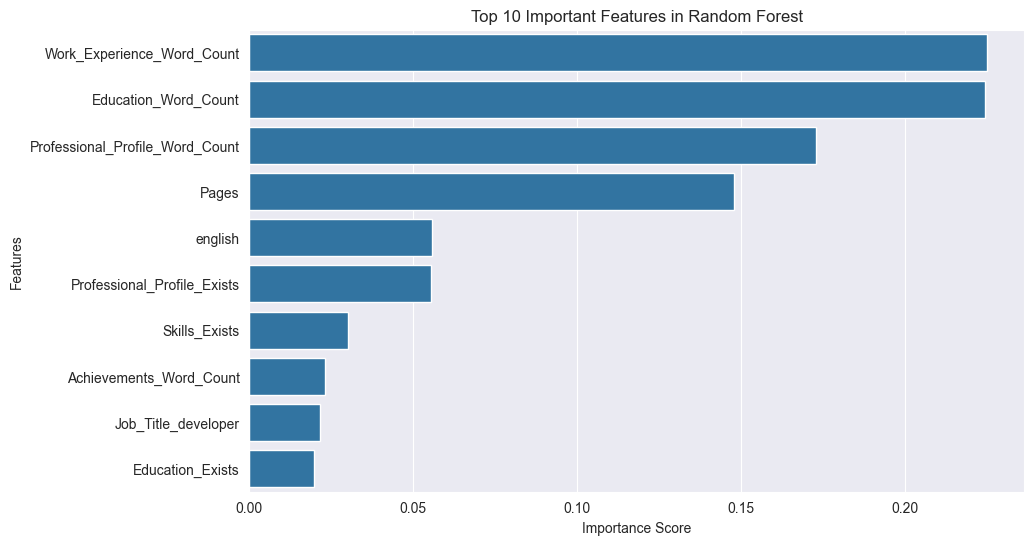

In [97]:
from bayes_opt import BayesianOptimization
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import roc_auc_score, classification_report

# Define function to evaluate model performance using Bayesian Optimization
def rf_evaluate(n_estimators, max_depth, min_samples_split, min_samples_leaf):
    params = {
        'n_estimators': int(n_estimators),
        'max_depth': int(max_depth),
        'min_samples_split': int(min_samples_split),
        'min_samples_leaf': int(min_samples_leaf),
        'random_state': 69
    }
    rf = RandomForestClassifier(**params)
    score = cross_val_score(rf, X_train, y_train, cv=5, scoring='roc_auc').mean()  # Use mean AUC score
    return score

# Define the parameter bounds for Bayesian Optimization
pbounds = {
    'n_estimators': (300, 1200),
    'max_depth': (5, 20),
    'min_samples_split': (2, 15),
    'min_samples_leaf': (1, 6)
}

# Initialize Bayesian Optimization
optimizer = BayesianOptimization(
    f=rf_evaluate,
    pbounds=pbounds,
    random_state=69,
)

# Run Bayesian Optimization
optimizer.maximize(init_points=10, n_iter=50)  # 10 random points, 50 optimization steps

# Extract the best parameters
best_params = optimizer.max['params']
print("🔹 Best Parameters Found:", best_params)

# Train the best Random Forest Model
best_rf = RandomForestClassifier(
    n_estimators=int(best_params['n_estimators']),
    max_depth=int(best_params['max_depth']),
    min_samples_split=int(best_params['min_samples_split']),
    min_samples_leaf=int(best_params['min_samples_leaf']),
    random_state=69
)
best_rf.fit(X_train, y_train)  # Train model

# Predict on test set
y_pred = best_rf.predict(X_test)
y_pred_proba = best_rf.predict_proba(X_test)[:, 1]

# Model Evaluation
auc_roc = roc_auc_score(y_test, y_pred_proba)
print(f"\n🔹 AUC-ROC Score: {auc_roc:.4f}")

print("\n🔹 Classification Report:\n", classification_report(y_test, y_pred))

# Feature Importance
feature_importances = pd.Series(best_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print("\n🔹 Top 10 Feature Importance:\n", feature_importances.head(10))

# Plot Feature Importance
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances.head(10), y=feature_importances.head(10).index)
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.title("Top 10 Important Features in Random Forest")
plt.show()


#### Ajustes
El recall es muy malo balanceamos el best_rf

In [99]:
best_rf = RandomForestClassifier(
    n_estimators=1009, max_depth=15,
    min_samples_split=5, min_samples_leaf=5,
    class_weight={0:1, 1:3},  # ⚡ Give more weight to "Passed" CVs
    random_state=69
)

best_rf.fit(X_train, y_train)  # Train model

# Predict on test set
y_pred = best_rf.predict(X_test)
y_pred_proba = best_rf.predict_proba(X_test)[:, 1]

# Model Evaluation
auc_roc = roc_auc_score(y_test, y_pred_proba)
print(f"\n🔹 AUC-ROC Score: {auc_roc:.4f}")

print("\n🔹 Classification Report:\n", classification_report(y_test, y_pred))

# Feature Importance
feature_importances = pd.Series(best_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print("\n🔹 Top 10 Feature Importance:\n", feature_importances.head(10))


🔹 AUC-ROC Score: 0.6396

🔹 Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.18      0.29        38
           1       0.38      0.83      0.52        23

    accuracy                           0.43        61
   macro avg       0.51      0.51      0.40        61
weighted avg       0.54      0.43      0.37        61


🔹 Top 10 Feature Importance:
 Education_Word_Count               0.228950
Work_Experience_Word_Count         0.220089
Professional_Profile_Word_Count    0.154409
Pages                              0.145853
english                            0.058011
Professional_Profile_Exists        0.055619
Skills_Exists                      0.033989
Job_Title_developer                0.027068
Achievements_Word_Count            0.026548
Education_Exists                   0.021543
dtype: float64


## Intentaremos nuevos modelos

### Regresión logistica

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix

df = pd.read_csv("../Bases/base_cvs/baseCVsJava.csv")
X = df.drop('Passed', axis=1)
y = df['Passed']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [12]:
df

,Education_Level_associate,Education_Level_bachelor,Education_Level_diploma,Education_Level_master,Education_Level_phd,Education_Level_unknown,Job_Title_architect,Job_Title_developer,Job_Title_engineer,Job_Title_manager,...,Professional_Profile_Exists,Professional_Profile_Word_Count,Projects_Exists,projects_Word_Count,volunteer_work_Exists,volunteer_work_Word_Count,Passed,english,french,spanish
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,1,0,0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1,4,1,101,0,0,0,1,0,0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,1,0,0,0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1,29,0,0,0,0,0,1,0,0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0,0,1,354,0,0,0,1,0,0
300,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1,10,0,0,0,0,1,0,0,0
301,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1,7,1,551,0,0,1,0,0,0
302,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1,47,1,12,0,0,0,0,0,0


In [3]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [4]:
logistic_regression = LogisticRegression(random_state=42)
logistic_regression.fit(X_train_scaled, y_train)

LogisticRegression(random_state=42)

In [5]:
y_pred = logistic_regression.predict(X_test_scaled)
y_pred_proba = logistic_regression.predict_proba(X_test_scaled)[:, 1]

In [8]:
accuracy = accuracy_score(y_test, y_pred)
classification_report_str = classification_report(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
confusion_matrix_val = confusion_matrix(y_test, y_pred)

print(f"Precisión: {accuracy:.2f}")
print(f"Reporte de clasificación:\n{classification_report_str}")
print(f"AUC-ROC: {roc_auc:.2f}")
print(f"Matriz de confusión:\n{confusion_matrix_val}")

Precisión: 0.59
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.67      0.72      0.69        60
           1       0.39      0.34      0.37        32

    accuracy                           0.59        92
   macro avg       0.53      0.53      0.53        92
weighted avg       0.57      0.59      0.58        92

AUC-ROC: 0.53
Matriz de confusión:
[[43 17]
 [21 11]]


### Usamos las variables que retiraron que nos dieron el mejor Random Forest

In [35]:
data_modelo_sumar_variables = df.drop(['Achievements_Exists', 'Keyword_Count', 'Education_Level_unknown', 'Job_Title_manager', 'Job_Title_developer', 'Total_Word_Count', 'Education_Level_bachelor', 'Keyword_Ratio', 'Education_Level_diploma', 'volunteer_work_Exists', 'Job_Title_unknown', 'Education_Word_Count', 'Certifications_Word_Count', 'Education_Level_phd', 'Education_Exists', 'Job_Title_architect', 'Professional_Profile_Word_Count', 'volunteer_work_Word_Count', 'Education_Level_master', 'Education_Level_associate', 'Work_Experience_Exists', 'Has_Colors', 'Job_Title_engineer'], axis=1)
X = data_modelo_sumar_variables.drop('Passed', axis=1)
y = data_modelo_sumar_variables['Passed']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [36]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [37]:
logistic_regression = LogisticRegression(random_state=42)
logistic_regression.fit(X_train_scaled, y_train)

LogisticRegression(random_state=42)

In [39]:
y_pred = logistic_regression.predict(X_test_scaled)
y_pred_proba = logistic_regression.predict_proba(X_test_scaled)[:, 1]

In [40]:
accuracy = accuracy_score(y_test, y_pred)
classification_report_str = classification_report(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
confusion_matrix_val = confusion_matrix(y_test, y_pred)

print(f"Precisión: {accuracy:.2f}")
print(f"Reporte de clasificación:\n{classification_report_str}")
print(f"AUC-ROC: {roc_auc:.2f}")
print(f"Matriz de confusión:\n{confusion_matrix_val}")

Precisión: 0.65
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.67      0.93      0.78        60
           1       0.50      0.12      0.20        32

    accuracy                           0.65        92
   macro avg       0.58      0.53      0.49        92
weighted avg       0.61      0.65      0.58        92

AUC-ROC: 0.57
Matriz de confusión:
[[56  4]
 [28  4]]


### Redes Neuronales

In [27]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers, Input
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix


In [28]:
df = pd.read_csv("../Bases/base_cvs/baseCVsJava.csv")
X = df.drop('Passed', axis=1)
y = df['Passed']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [29]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [30]:
model = keras.Sequential([
    Input(shape=(X_train_scaled.shape[1],)),  # Capa Input
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')  # Función de activación sigmoide para clasificación binaria
])

In [31]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # Función de pérdida para clasificación binaria
              metrics=['AUC'])

In [32]:
model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - AUC: 0.4569 - loss: 0.8079 - val_AUC: 0.4919 - val_loss: 0.7160
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.4785 - loss: 0.7284 - val_AUC: 0.5197 - val_loss: 0.6761
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.5177 - loss: 0.7115 - val_AUC: 0.5312 - val_loss: 0.6719
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.5756 - loss: 0.6607 - val_AUC: 0.5289 - val_loss: 0.6684
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6439 - loss: 0.6462 - val_AUC: 0.5509 - val_loss: 0.6650
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.5705 - loss: 0.6707 - val_AUC: 0.5509 - val_loss: 0.6654
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.5963 - loss: 0.6554 - val_AUC: 0.5567 - val_loss: 0.6679
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.5992 - loss: 0.6628 - val_AUC: 0.5648 - val_loss: 0.6657
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.6674 - loss: 0.6302 - val_AUC:

In [33]:
y_pred_proba = model.predict(X_test_scaled)
y_pred = (y_pred_proba > 0.5).astype(int)  # Convertir probabilidades a clases (0 o 1)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


In [34]:
accuracy = accuracy_score(y_test, y_pred)
classification_report_str = classification_report(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
confusion_matrix_val = confusion_matrix(y_test, y_pred)

print(f"Precisión: {accuracy:.2f}")
print(f"Reporte de clasificación:\n{classification_report_str}")
print(f"AUC-ROC: {roc_auc:.2f}")
print(f"Matriz de confusión:\n{confusion_matrix_val}")

Precisión: 0.54
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.63      0.72      0.67        60
           1       0.29      0.22      0.25        32

    accuracy                           0.54        92
   macro avg       0.46      0.47      0.46        92
weighted avg       0.51      0.54      0.53        92

AUC-ROC: 0.51
Matriz de confusión:
[[43 17]
 [25  7]]


### Intentamos con las mejores variables

In [46]:
data_modelo_sumar_variables = df.drop(['Achievements_Exists', 'Keyword_Count', 'Education_Level_unknown', 'Job_Title_manager', 'Job_Title_developer', 'Total_Word_Count', 'Education_Level_bachelor', 'Keyword_Ratio', 'Education_Level_diploma', 'volunteer_work_Exists', 'Job_Title_unknown', 'Education_Word_Count', 'Certifications_Word_Count', 'Education_Level_phd', 'Education_Exists', 'Job_Title_architect', 'Professional_Profile_Word_Count', 'volunteer_work_Word_Count', 'Education_Level_master', 'Education_Level_associate', 'Work_Experience_Exists', 'Has_Colors', 'Job_Title_engineer'], axis=1)
X = data_modelo_sumar_variables.drop('Passed', axis=1)
y = data_modelo_sumar_variables['Passed']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [47]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [48]:
model = keras.Sequential([
    Input(shape=(X_train_scaled.shape[1],)),  # Capa Input
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')  # Función de activación sigmoide para clasificación binaria
])

In [49]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # Función de pérdida para clasificación binaria
              metrics=['AUC'])

In [53]:
model.fit(X_train_scaled, y_train, epochs=1000, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - AUC: 0.7137 - loss: 0.5971 - val_AUC: 0.4363 - val_loss: 0.8585
Epoch 2/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7133 - loss: 0.5710 - val_AUC: 0.4537 - val_loss: 0.8541
Epoch 3/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7370 - loss: 0.5590 - val_AUC: 0.4583 - val_loss: 0.8565
Epoch 4/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7909 - loss: 0.5232 - val_AUC: 0.4630 - val_loss: 0.8609
Epoch 5/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7903 - loss: 0.5236 - val_AUC: 0.4560 - val_loss: 0.8684
Epoch 6/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7587 - loss: 0.5555 - val_AUC: 0.4549 - val_loss: 0.8720
Epoch 7/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7569 - loss: 0.5652 - val_AUC: 0.4560 - val_loss: 0.8781
Epoch 8/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.7483 - loss: 0.5670 - val_AUC: 0.4560 - val_loss: 0.8877
Epoch 9/1000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.7518 - loss: 

In [54]:
y_pred_proba = model.predict(X_test_scaled)
y_pred = (y_pred_proba > 0.5).astype(int)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [55]:
accuracy = accuracy_score(y_test, y_pred)
classification_report_str = classification_report(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
confusion_matrix_val = confusion_matrix(y_test, y_pred)

print(f"Precisión: {accuracy:.2f}")
print(f"Reporte de clasificación:\n{classification_report_str}")
print(f"AUC-ROC: {roc_auc:.2f}")
print(f"Matriz de confusión:\n{confusion_matrix_val}")

Precisión: 0.59
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.68      0.70      0.69        60
           1       0.40      0.38      0.39        32

    accuracy                           0.59        92
   macro avg       0.54      0.54      0.54        92
weighted avg       0.58      0.59      0.58        92

AUC-ROC: 0.51
Matriz de confusión:
[[42 18]
 [20 12]]
